## Importar Bibliotecas e Carregar Dataset Preprocessado

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

import sklearn

print("Bibliotecas importadas com sucesso!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

Bibliotecas importadas com sucesso!
Pandas: 2.3.3
NumPy: 2.3.3
Scikit-learn: 1.7.2


In [2]:
# Carregamento e preparação inicial dos dados
print("Carregando datasets...")

# Carregar datasets pré-processados
train_data = pd.read_csv('dataset_sepsis_prepared.csv')
test_data = pd.read_csv('dataset_sepsis_test_prepared.csv')

print(f"Dataset de treino: {train_data.shape}")
print(f"Dataset de teste: {test_data.shape}")

# Separar features e target
X_train = train_data.drop('SepsisLabel', axis=1)
y_train = train_data['SepsisLabel']
X_test = test_data.drop('SepsisLabel', axis=1)
y_test = test_data['SepsisLabel']

# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nDistribuição das classes:")
print("Treino:", y_train.value_counts().to_dict())
print("Teste:", y_test.value_counts().to_dict())

print("\nDados preparados e normalizados com sucesso!")

Carregando datasets...
Dataset de treino: (853006, 19)
Dataset de teste: (215171, 19)
Dataset de treino: (853006, 19)
Dataset de teste: (215171, 19)

Distribuição das classes:
Treino: {0.0: 831112, 1.0: 21894}
Teste: {0.0: 209675, 1.0: 5496}

Dados preparados e normalizados com sucesso!

Distribuição das classes:
Treino: {0.0: 831112, 1.0: 21894}
Teste: {0.0: 209675, 1.0: 5496}

Dados preparados e normalizados com sucesso!


## 1. Sampling para Busca de Hiperparâmetros

In [ ]:
# ======================================================================
# SAMPLING ESTRATIFICADO PARA BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===")

# Dataset completo é muito grande (>1M instâncias) para busca de hiperparâmetros
# Vamos usar uma amostra estratificada de 4% para otimização
from sklearn.model_selection import train_test_split

# Amostra estratificada de 4% do dataset de treino
_, X_sample, _, y_sample = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.04,  # 4% do dataset
    stratify=y_train,
    random_state=42
)

print(f"Dataset original de treino: {X_train_scaled.shape[0]:,} amostras")
print(f"Amostra para busca de hiperparâmetros: {X_sample.shape[0]:,} amostras")
print(f"Redução: {(1 - X_sample.shape[0]/X_train_scaled.shape[0])*100:.1f}%")

print("\nDistribuição das classes na amostra:")
print("Amostra:", pd.Series(y_sample).value_counts().to_dict())
print("Original:", y_train.value_counts().to_dict())

print("\n✅ Amostra preparada para busca de hiperparâmetros!")

## 2. Funções Auxiliares

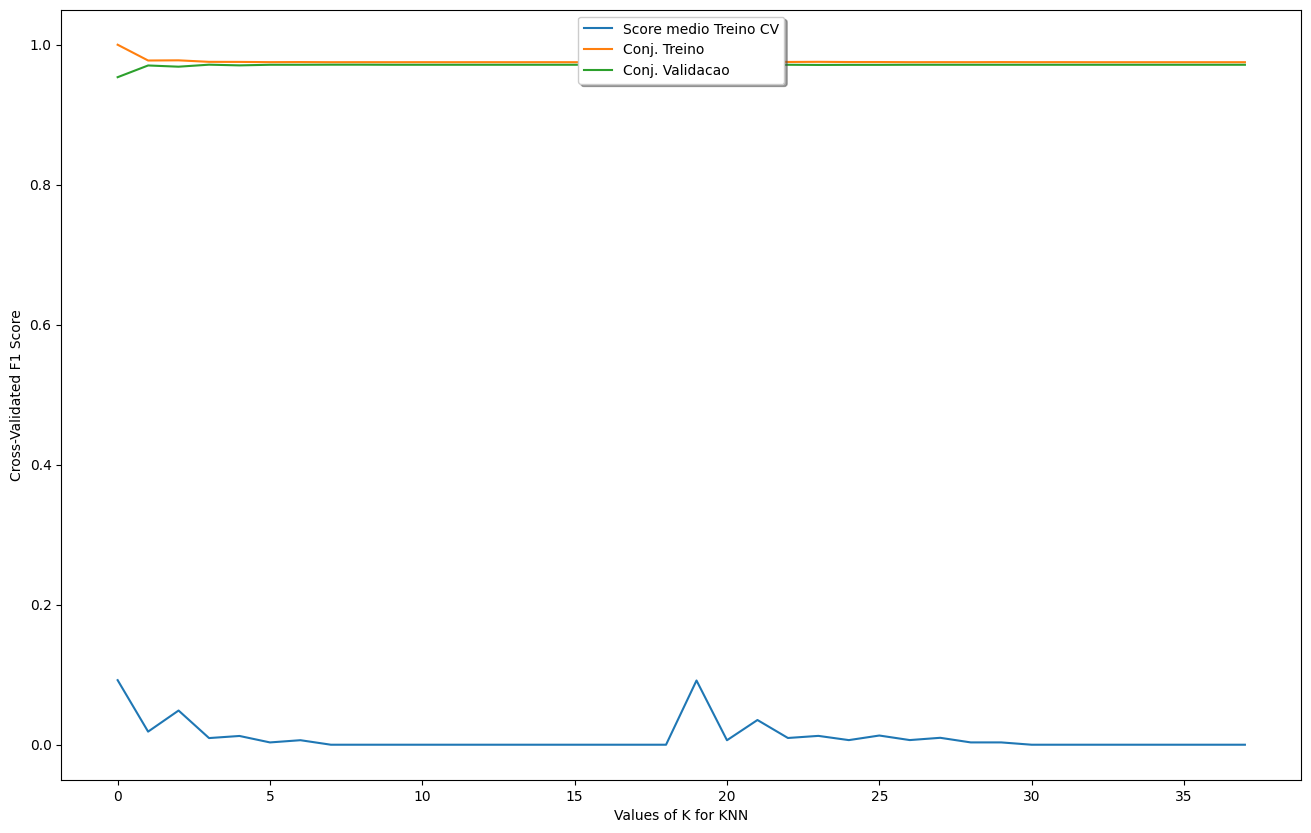

Acuracia de treinamento clf: 0.975
Acuracia de teste clf: 0.974


In [ ]:
# Função auxiliar para cálculo do G-Mean
def gmean_score(y_true, y_pred):
    """Calcula o G-Mean (Geometric Mean) para problemas binários"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    return np.sqrt(sensitivity * specificity)

# Função para avaliar modelos
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Avalia um modelo treinado e retorna métricas completas"""
    # Predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métricas de treino
    train_metrics = {
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'f1': f1_score(y_train, y_train_pred),
        'gmean': gmean_score(y_train, y_train_pred)
    }
    
    # Métricas de teste
    test_metrics = {
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'gmean': gmean_score(y_test, y_test_pred)
    }
    
    # AUC se o modelo suporta predict_proba
    try:
        y_test_proba = model.predict_proba(X_test)[:, 1]
        test_metrics['auc_roc'] = roc_auc_score(y_test, y_test_proba)
    except:
        test_metrics['auc_roc'] = None
    
    return train_metrics, test_metrics, y_test_pred

# Função para plotar histórico de busca
def plot_search_history(search_results, model_name, metric='mean_test_f1'):
    """Plota a evolução dos resultados durante a busca de hiperparâmetros"""
    plt.figure(figsize=(12, 6))
    
    results_df = pd.DataFrame(search_results.cv_results_)
    
    plt.subplot(1, 2, 1)
    plt.plot(results_df[metric], 'b-o', alpha=0.7)
    plt.fill_between(range(len(results_df)), 
                     results_df[metric] - results_df[f'std_test_f1'],
                     results_df[metric] + results_df[f'std_test_f1'], 
                     alpha=0.3)
    plt.title(f'{model_name} - Evolução do F1-Score')
    plt.xlabel('Iteração')
    plt.ylabel('F1-Score (CV)')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(results_df['mean_train_f1'], 'g-o', alpha=0.7, label='Treino')
    plt.plot(results_df[metric], 'b-o', alpha=0.7, label='Validação')
    plt.title(f'{model_name} - Treino vs Validação')
    plt.xlabel('Iteração')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Função para executar múltiplas buscas de hiperparâmetros
def multiple_randomized_search(estimator, param_distributions, X, y, cv_strategy, 
                              n_searches=20, n_iter_per_search=80, scoring='f1', 
                              random_state=42, n_jobs=-1, verbose=1):
    """
    Executa múltiplas buscas RandomizedSearchCV e retorna a melhor configuração global
    
    Parameters:
    -----------
    n_searches : int
        Número de execuções do RandomizedSearchCV (default: 20)
    n_iter_per_search : int  
        Número de iterações por execução (default: 80)
    """
    print(f"Executando {n_searches} buscas com {n_iter_per_search} iterações cada...")
    
    best_overall_score = -np.inf
    best_overall_params = None
    best_search_result = None
    all_results = []
    
    for search_idx in range(n_searches):
        print(f"\nBusca {search_idx + 1}/{n_searches}...")
        
        # RandomizedSearchCV para esta execução
        search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_distributions,
            n_iter=n_iter_per_search,
            scoring=scoring,
            cv=cv_strategy,
            random_state=random_state + search_idx,  # Seed diferente para cada busca
            n_jobs=n_jobs,
            return_train_score=True,
            verbose=0  # Menos verbose para múltiplas execuções
        )
        
        search.fit(X, y)
        
        # Armazenar resultados desta busca
        search_results = {
            'search_idx': search_idx,
            'best_score': search.best_score_,
            'best_params': search.best_params_,
            'cv_results': search.cv_results_
        }
        all_results.append(search_results)
        
        # Verificar se esta é a melhor busca até agora
        if search.best_score_ > best_overall_score:
            best_overall_score = search.best_score_
            best_overall_params = search.best_params_
            best_search_result = search
            
        print(f"Melhor score desta busca: {search.best_score_:.4f}")
        print(f"Melhor score geral até agora: {best_overall_score:.4f}")
    
    print(f"\n🎯 Busca completa! Melhor score geral: {best_overall_score:.4f}")
    print(f"Total de configurações testadas: {n_searches * n_iter_per_search:,}")
    
    return best_search_result, all_results

print("Funções auxiliares definidas com sucesso!")

## 3. KNN - Busca de Hiperparâmetros

In [ ]:
# ======================================================================
# 4.1 K-NEAREST NEIGHBORS (KNN) - BUSCA DE HIPERPARAMETROS
# ======================================================================

print("=== BUSCA DE HIPERPARÂMETROS - KNN ===")

# 4.3 Definição do Espaço de Hiperparâmetros para KNN
knn_param_distributions = {
    'n_neighbors': randint(3, 20),           # Número de vizinhos
    'metric': ['euclidean', 'manhattan'],    # Métrica de distância
    'weights': ['uniform', 'distance'],      # Peso dos vizinhos
    'p': [1, 2]                             # Parâmetro para métrica Minkowski
}

# Configuração da validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4.1 Múltiplas execuções do RandomizedSearchCV (20 buscas x 80 iterações = 1600 configurações)
print("Iniciando busca de hiperparâmetros para KNN...")
knn_search, knn_all_searches = multiple_randomized_search(
    estimator=KNeighborsClassifier(),
    param_distributions=knn_param_distributions,
    X=X_sample,                   # Usando amostra de 4%
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,                
    n_iter_per_search=20,        
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 5.1 Seleção da Melhor Configuração
print("\n--- RESULTADOS KNN ---")
print("Melhores hiperparâmetros:")
for param, value in knn_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {knn_search.best_score_:.4f}")

# 4.4 Registro de Desempenho - plotar evolução
plot_search_history(knn_search, "KNN")

# 5.2 Treinamento Final com dataset completo usando melhores hiperparâmetros
best_knn = KNeighborsClassifier(**knn_search.best_params_)
best_knn.fit(X_train_scaled, y_train)  # Treino com dataset completo
print(f"\nModelo final KNN treinado com dataset completo: {best_knn}")

# Armazenar resultados
knn_results = {
    'model': best_knn,
    'search': knn_search,
    'best_params': knn_search.best_params_,
    'best_cv_score': knn_search.best_score_
}

## 4. LVQ - Busca de Hiperparâmetros 

In [ ]:
# ======================================================================
# 4.2 LEARNING VECTOR QUANTIZATION (LVQ) - IMPLEMENTAÇÃO E BUSCA
# ======================================================================


# Implementação do LVQ como Estimador compatível com scikit-learn
from sklearn.base import BaseEstimator, ClassifierMixin

class LVQClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, prototypes_per_class=1, n_epochs=100, learning_rate=0.01, random_state=None):
        """
        prototypes_per_class : int
            Número de protótipos a serem usados para cada classe.
        n_epochs : int
            Número de épocas (iterações completas sobre os dados de treinamento).
        learning_rate : float
            Taxa de aprendizado utilizada para atualizar os protótipos.
        random_state : int ou None
            Semente para reprodutibilidade.
        """
        self.prototypes_per_class = prototypes_per_class
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.random_state = random_state

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        # Determina as classes únicas
        self.classes_ = np.unique(y)
        n_features = X.shape[1]

        # Inicializa os protótipos
        prototypes = []
        prototype_labels = []
        for c in self.classes_:
            X_c = X[y == c]
            # Se a quantidade de exemplos dessa classe for menor que o número de protótipos desejados
            replace_flag = X_c.shape[0] < self.prototypes_per_class
            indices = np.random.choice(X_c.shape[0], size=self.prototypes_per_class, replace=replace_flag)
            prototypes.append(X_c[indices])
            prototype_labels.extend([c] * self.prototypes_per_class)
            
        self.prototypes_ = np.vstack(prototypes)
        self.prototype_labels_ = np.array(prototype_labels)

        # Treinamento – Algoritmo LVQ
        for epoch in range(self.n_epochs):
            # Embaralha os índices dos exemplos
            indices = np.random.permutation(X.shape[0])
            for i in indices:
                xi = X[i]
                yi = y[i]
                # Calcula as distâncias euclidianas do exemplo xi a todos os protótipos
                distances = np.linalg.norm(self.prototypes_ - xi, axis=1)
                # Encontra o índice do protótipo mais próximo
                j = np.argmin(distances)
                # Atualiza o protótipo:
                if self.prototype_labels_[j] == yi:
                    # Se a classe coincide, aproxima o protótipo do exemplo
                    self.prototypes_[j] += self.learning_rate * (xi - self.prototypes_[j])
                else:
                    # Se as classes forem diferentes, afasta o protótipo do exemplo
                    self.prototypes_[j] -= self.learning_rate * (xi - self.prototypes_[j])
        return self

    def predict(self, X):
        X = np.array(X)
        y_pred = []
        # Para cada exemplo, calcula a distância para cada protótipo
        for xi in X:
            distances = np.linalg.norm(self.prototypes_ - xi, axis=1)
            j = np.argmin(distances)
            y_pred.append(self.prototype_labels_[j])
        return np.array(y_pred)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

print("=== BUSCA DE HIPERPARÂMETROS - LVQ ===")

# 4.3 Definição do Espaço de Hiperparâmetros para LVQ
lvq_param_distributions = {
    'prototypes_per_class': randint(1, 6),      # Número de protótipos por classe
    'n_epochs': randint(50, 200),               # Número de épocas
    'learning_rate': uniform(0.001, 0.1)       # Taxa de aprendizado
}

# 4.1 Múltiplas execuções do RandomizedSearchCV (20 buscas x 80 iterações = 1600 configurações)
print("Iniciando busca de hiperparâmetros para LVQ...")
lvq_search, lvq_all_searches = multiple_randomized_search(
    estimator=LVQClassifier(random_state=42),
    param_distributions=lvq_param_distributions,
    X=X_sample,                   # Usando amostra de 4%
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,                
    n_iter_per_search=20,        
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 5.1 Seleção da Melhor Configuração
print("\n--- RESULTADOS LVQ ---")
print("Melhores hiperparâmetros:")
for param, value in lvq_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {lvq_search.best_score_:.4f}")

# 4.4 Registro de Desempenho - plotar evolução
plot_search_history(lvq_search, "LVQ")

# 5.2 Treinamento Final com dataset completo usando melhores hiperparâmetros
best_lvq = LVQClassifier(**lvq_search.best_params_)
best_lvq.fit(X_train_scaled, y_train)  # Treino com dataset completo
print(f"\nModelo final LVQ treinado com dataset completo: {best_lvq}")

# Armazenar resultados
lvq_results = {
    'model': best_lvq,
    'search': lvq_search,
    'best_params': lvq_search.best_params_,
    'best_cv_score': lvq_search.best_score_
}

## 5. SVM - Busca de Hiperparâmetros

In [ ]:
# ======================================================================
# 4.2 SUPPORT VECTOR MACHINE (SVM) - BUSCA DE HIPERPARAMETROS
# ======================================================================

print("=== BUSCA DE HIPERPARÂMETROS - SVM ===")

# 4.3 Definição do Espaço de Hiperparâmetros para SVM
svm_param_distributions = {
    'C': uniform(0.1, 100),                    # Distribuição log-uniforme para C
    'kernel': ['rbf', 'linear', 'poly'],       # Tipos de kernel
    'gamma': ['scale', 'auto'] + list(uniform(0.001, 1).rvs(10))  # Parâmetro gamma
}

# 4.1 Múltiplas execuções do RandomizedSearchCV (20 buscas x 80 iterações = 1600 configurações)
print("Iniciando busca de hiperparâmetros para SVM...")
svm_search, svm_all_searches = multiple_randomized_search(
    estimator=SVC(random_state=42),
    param_distributions=svm_param_distributions,
    X=X_sample,                   # Usando amostra de 4%
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,               
    n_iter_per_search=20,         
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 5.1 Seleção da Melhor Configuração
print("\n--- RESULTADOS SVM ---")
print("Melhores hiperparâmetros:")
for param, value in svm_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {svm_search.best_score_:.4f}")

# 4.4 Registro de Desempenho - plotar evolução
plot_search_history(svm_search, "SVM")

# 5.2 Treinamento Final com dataset completo usando melhores hiperparâmetros
best_svm = SVC(**svm_search.best_params_)
best_svm.fit(X_train_scaled, y_train)  # Treino com dataset completo
print(f"\nModelo final SVM treinado com dataset completo: {best_svm}")

# Armazenar resultados
svm_results = {
    'model': best_svm,
    'search': svm_search,
    'best_params': svm_search.best_params_,
    'best_cv_score': svm_search.best_score_
}

## 7. Random Forest - Busca de Hiperparâmetros

In [ ]:
# ======================================================================
# 4.3 RANDOM FOREST - BUSCA DE HIPERPARAMETROS
# ======================================================================

print("=== BUSCA DE HIPERPARÂMETROS - RANDOM FOREST ===")

# 4.3 Definição do Espaço de Hiperparâmetros para Random Forest
rf_param_distributions = {
    'n_estimators': randint(50, 300),           # Distribuição inteira de 50 a 300
    'max_depth': randint(3, 20),                # Distribuição inteira de 3 a 20
    'min_samples_split': randint(2, 20),        # Mínimo de amostras para dividir
    'min_samples_leaf': randint(1, 10),         # Mínimo de amostras por folha
    'max_features': ['sqrt', 'log2', None]      # Número máximo de features
}

# 4.1 Múltiplas execuções do RandomizedSearchCV (20 buscas x 80 iterações = 1600 configurações)
print("Iniciando busca de hiperparâmetros para Random Forest...")
rf_search, rf_all_searches = multiple_randomized_search(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_distributions,
    X=X_sample,                   # Usando amostra de 4%
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,               
    n_iter_per_search=20,         
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 5.1 Seleção da Melhor Configuração
print("\n--- RESULTADOS RANDOM FOREST ---")
print("Melhores hiperparâmetros:")
for param, value in rf_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {rf_search.best_score_:.4f}")

# 4.4 Registro de Desempenho - plotar evolução
plot_search_history(rf_search, "Random Forest")

# 5.2 Treinamento Final com dataset completo usando melhores hiperparâmetros
best_rf = RandomForestClassifier(**rf_search.best_params_)
best_rf.fit(X_train_scaled, y_train)  # Treino com dataset completo
print(f"\nModelo final Random Forest treinado com dataset completo: {best_rf}")

# Armazenar resultados
rf_results = {
    'model': best_rf,
    'search': rf_search,
    'best_params': rf_search.best_params_,
    'best_cv_score': rf_search.best_score_
}

## 8. Decision Tree - Busca de Hiperparâmetros

In [ ]:
# ======================================================================
# 4.4 DECISION TREE - BUSCA DE HIPERPARAMETROS
# ======================================================================

print("=== BUSCA DE HIPERPARÂMETROS - DECISION TREE ===")

# 4.3 Definição do Espaço de Hiperparâmetros para Decision Tree
dt_param_distributions = {
    'max_depth': randint(3, 20),                    # Profundidade máxima
    'min_samples_split': randint(2, 20),            # Mínimo de amostras para dividir
    'min_samples_leaf': randint(1, 10),             # Mínimo de amostras por folha
    'criterion': ['gini', 'entropy'],               # Critério de divisão
    'max_features': ['sqrt', 'log2', None]          # Número máximo de features
}

# 4.1 Múltiplas execuções do RandomizedSearchCV (20 buscas x 80 iterações = 1600 configurações)
print("Iniciando busca de hiperparâmetros para Decision Tree...")
dt_search, dt_all_searches = multiple_randomized_search(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=dt_param_distributions,
    X=X_sample,                   # Usando amostra de 4%
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,               
    n_iter_per_search=20,         
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 5.1 Seleção da Melhor Configuração
print("\n--- RESULTADOS DECISION TREE ---")
print("Melhores hiperparâmetros:")
for param, value in dt_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {dt_search.best_score_:.4f}")

# 4.4 Registro de Desempenho - plotar evolução
plot_search_history(dt_search, "Decision Tree")

# 5.2 Treinamento Final com dataset completo usando melhores hiperparâmetros
best_dt = DecisionTreeClassifier(**dt_search.best_params_)
best_dt.fit(X_train_scaled, y_train)  # Treino com dataset completo
print(f"\nModelo final Decision Tree treinado com dataset completo: {best_dt}")

# Armazenar resultados
dt_results = {
    'model': best_dt,
    'search': dt_search,
    'best_params': dt_search.best_params_,
    'best_cv_score': dt_search.best_score_
}

## 9. Monitoramento e Avaliação dos Modelos

In [ ]:
# ======================================================================
# 5.3 AVALIAÇÃO NO CONJUNTO DE TESTE
# ======================================================================

print("=== AVALIAÇÃO FINAL DOS MODELOS NO CONJUNTO DE TESTE ===")

# Dicionário para armazenar todos os modelos
models = {
    'KNN': knn_results,
    'LVQ': lvq_results,
    'SVM': svm_results,
    'Random Forest': rf_results,
    'Decision Tree': dt_results
}

# Dicionário para armazenar resultados finais
final_results = {}

# Avaliar cada modelo no conjunto de teste
for model_name, model_info in models.items():
    print(f"\n--- Avaliando {model_name} ---")
    
    model = model_info['model']
    
    # 5.3 Avaliação no conjunto de teste
    train_metrics, test_metrics, y_pred = evaluate_model(
        model, X_train_scaled, X_test_scaled, y_train, y_test, model_name
    )
    
    # Armazenar resultados
    final_results[model_name] = {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'predictions': y_pred,
        'best_params': model_info['best_params'],
        'cv_score': model_info['best_cv_score']
    }
    
    print(f"F1-Score CV: {model_info['best_cv_score']:.4f}")
    print(f"F1-Score Teste: {test_metrics['f1']:.4f}")
    print(f"Acurácia Teste: {test_metrics['accuracy']:.4f}")
    print(f"Recall Teste: {test_metrics['recall']:.4f}")
    print(f"Precisão Teste: {test_metrics['precision']:.4f}")
    print(f"G-Mean Teste: {test_metrics['gmean']:.4f}")
    if test_metrics['auc_roc']:
        print(f"AUC-ROC Teste: {test_metrics['auc_roc']:.4f}")

print("\nAvaliação de todos os modelos concluída!")

## 10. Comparação e Análise dos Resultados

In [ ]:
# ======================================================================
# 6.1 COMPARAÇÃO DE DESEMPENHO - GRÁFICOS E ANÁLISES
# ======================================================================

# Criar DataFrame com métricas para comparação
metrics_data = []
for model_name, results in final_results.items():
    train_metrics = results['train_metrics']
    test_metrics = results['test_metrics']
    
    metrics_data.append({
        'Modelo': model_name,
        'F1_CV': results['cv_score'],
        'F1_Treino': train_metrics['f1'],
        'F1_Teste': test_metrics['f1'],
        'Acurácia_Teste': test_metrics['accuracy'],
        'Precisão_Teste': test_metrics['precision'],
        'Recall_Teste': test_metrics['recall'],
        'G-Mean_Teste': test_metrics['gmean'],
        'AUC_ROC_Teste': test_metrics['auc_roc'] if test_metrics['auc_roc'] else 0
    })

metrics_df = pd.DataFrame(metrics_data)
print("=== RESUMO COMPARATIVO DOS MODELOS ===")
print(metrics_df.round(4))

# 6.1 Gráficos de comparação
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Comparação de F1-Score
ax1 = axes[0, 0]
x_pos = np.arange(len(metrics_df))
ax1.bar(x_pos - 0.2, metrics_df['F1_CV'], 0.4, label='F1-Score CV', alpha=0.8)
ax1.bar(x_pos + 0.2, metrics_df['F1_Teste'], 0.4, label='F1-Score Teste', alpha=0.8)
ax1.set_xlabel('Modelos')
ax1.set_ylabel('F1-Score')
ax1.set_title('Comparação F1-Score: CV vs Teste')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(metrics_df['Modelo'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Comparação de múltiplas métricas
ax2 = axes[0, 1]
metrics_to_plot = ['Acurácia_Teste', 'Precisão_Teste', 'Recall_Teste', 'G-Mean_Teste']
x_pos = np.arange(len(metrics_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    ax2.bar(x_pos + (i-1.5)*width, metrics_df[metric], width, 
            label=metric.replace('_Teste', ''), alpha=0.8)

ax2.set_xlabel('Modelos')
ax2.set_ylabel('Score')
ax2.set_title('Comparação de Múltiplas Métricas')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(metrics_df['Modelo'], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Boxplot para verificar overfitting
ax3 = axes[1, 0]
overfitting_data = []
models_names = []
for model_name, results in final_results.items():
    f1_train = results['train_metrics']['f1']
    f1_test = results['test_metrics']['f1']
    overfitting_data.append([f1_train, f1_test])
    models_names.append(model_name)

overfitting_df = pd.DataFrame(overfitting_data, 
                             columns=['Treino', 'Teste'], 
                             index=models_names)

overfitting_df.plot(kind='bar', ax=ax3, alpha=0.8)
ax3.set_title('Overfitting: F1-Score Treino vs Teste')
ax3.set_ylabel('F1-Score')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Gráfico 4: AUC-ROC Comparison (para modelos que suportam)
ax4 = axes[1, 1]
auc_data = metrics_df[metrics_df['AUC_ROC_Teste'] > 0]
if not auc_data.empty:
    ax4.bar(auc_data['Modelo'], auc_data['AUC_ROC_Teste'], alpha=0.8, color='purple')
    ax4.set_xlabel('Modelos')
    ax4.set_ylabel('AUC-ROC')
    ax4.set_title('Comparação AUC-ROC')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'AUC-ROC não disponível\npara todos os modelos', 
             ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('AUC-ROC Comparison')

plt.tight_layout()
plt.show()

In [ ]:
# ======================================================================
# 6.2 MATRIZES DE CONFUSÃO E CURVAS ROC
# ======================================================================

# Plotar matrizes de confusão para todos os modelos
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (model_name, results) in enumerate(final_results.items()):
    y_pred = results['predictions']
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    # Plotar matriz de confusão
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Matriz de Confusão - {model_name}')
    axes[idx].set_xlabel('Predito')
    axes[idx].set_ylabel('Real')

plt.tight_layout()
plt.show()

# ======================================================================
# 6.3 CURVAS ROC (para modelos que suportam predict_proba)
# ======================================================================

plt.figure(figsize=(10, 8))

for model_name, results in final_results.items():
    model = models[model_name]['model']
    
    try:
        # Obter probabilidades
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Calcular curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        
        # Plotar curva ROC
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')
        
    except Exception as e:
        print(f"Não foi possível plotar ROC para {model_name}: {e}")

# Linha diagonal (classificador aleatório)
plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório')

plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC - Comparação de Modelos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# ======================================================================
# 6.4 ANÁLISE DE OVERFITTING vs UNDERFITTING
# ======================================================================

print("=== ANÁLISE DE OVERFITTING vs UNDERFITTING ===")

overfitting_analysis = []

for model_name, results in final_results.items():
    f1_train = results['train_metrics']['f1']
    f1_cv = results['cv_score']
    f1_test = results['test_metrics']['f1']
    
    # Diferenças entre treino e validação/teste
    train_cv_diff = f1_train - f1_cv
    train_test_diff = f1_train - f1_test
    cv_test_diff = f1_cv - f1_test
    
    # Classificação do overfitting/underfitting
    if train_test_diff > 0.1:  # Diferença significativa
        fitting_status = "Overfitting"
    elif f1_test < 0.6:  # Performance baixa em geral
        fitting_status = "Underfitting"
    else:
        fitting_status = "Bem ajustado"
    
    overfitting_analysis.append({
        'Modelo': model_name,
        'F1_Treino': f1_train,
        'F1_CV': f1_cv,
        'F1_Teste': f1_test,
        'Diff_Treino_CV': train_cv_diff,
        'Diff_Treino_Teste': train_test_diff,
        'Diff_CV_Teste': cv_test_diff,
        'Status': fitting_status
    })

overfitting_df = pd.DataFrame(overfitting_analysis)
print(overfitting_df.round(4))

# ======================================================================
# 6.5 MELHORES HIPERPARÂMETROS E DISCUSSÃO
# ======================================================================

print("\n=== MELHORES HIPERPARÂMETROS POR MODELO ===")

for model_name, results in final_results.items():
    print(f"\n{model_name}:")
    print(f"  F1-Score CV: {results['cv_score']:.4f}")
    print(f"  F1-Score Teste: {results['test_metrics']['f1']:.4f}")
    print("  Melhores hiperparâmetros:")
    for param, value in results['best_params'].items():
        print(f"    {param}: {value}")

# ======================================================================
# 6.6 IDENTIFICAÇÃO DO MELHOR MODELO
# ======================================================================

print("\n=== IDENTIFICAÇÃO DO MELHOR MODELO ===")

# Ordenar modelos por F1-Score no teste
best_models = sorted(final_results.items(), 
                    key=lambda x: x[1]['test_metrics']['f1'], 
                    reverse=True)

print("Ranking dos modelos por F1-Score no conjunto de teste:")
for i, (model_name, results) in enumerate(best_models):
    print(f"{i+1}. {model_name}: {results['test_metrics']['f1']:.4f}")

best_model_name = best_models[0][0]
best_model_results = best_models[0][1]

print(f"\n🏆 MELHOR MODELO: {best_model_name}")
print(f"F1-Score (Teste): {best_model_results['test_metrics']['f1']:.4f}")
print(f"Acurácia (Teste): {best_model_results['test_metrics']['accuracy']:.4f}")
print(f"Precisão (Teste): {best_model_results['test_metrics']['precision']:.4f}")
print(f"Recall (Teste): {best_model_results['test_metrics']['recall']:.4f}")
print(f"G-Mean (Teste): {best_model_results['test_metrics']['gmean']:.4f}")

if best_model_results['test_metrics']['auc_roc']:
    print(f"AUC-ROC (Teste): {best_model_results['test_metrics']['auc_roc']:.4f}")

print("\nMelhores hiperparâmetros:")
for param, value in best_model_results['best_params'].items():
    print(f"  {param}: {value}")

## 11. Conclusões e Implicações dos Resultados

In [ ]:
# ======================================================================
# CONCLUSÕES E IMPLICAÇÕES DOS RESULTADOS
# ======================================================================

print("=== CONCLUSÕES FINAIS ===")

print(f"""
📊 RESUMO DOS RESULTADOS:

🏆 MELHOR MODELO: {best_model_name}
   • F1-Score no teste: {best_model_results['test_metrics']['f1']:.4f}
   • Acurácia no teste: {best_model_results['test_metrics']['accuracy']:.4f}
   • Recall no teste: {best_model_results['test_metrics']['recall']:.4f}
   • Precisão no teste: {best_model_results['test_metrics']['precision']:.4f}

📈 COMPARAÇÃO GERAL:
""")

for i, (model_name, results) in enumerate(best_models):
    status_emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "📍"
    print(f"   {status_emoji} {model_name}: F1 = {results['test_metrics']['f1']:.4f}")

print(f"""
🔍 ANÁLISE DE OVERFITTING:
""")

for _, row in overfitting_df.iterrows():
    emoji = "⚠️" if row['Status'] == 'Overfitting' else "🔻" if row['Status'] == 'Underfitting' else "✅"
    print(f"   {emoji} {row['Modelo']}: {row['Status']} (Diff Treino-Teste: {row['Diff_Treino_Teste']:.3f})")

print(f"""
💡 IMPLICAÇÕES PARA O PROBLEMA DE SEPSE:

1. 🎯 MODELO RECOMENDADO: {best_model_name}
   • Apresentou o melhor equilíbrio entre precisão e recall
   • Demonstrou boa generalização para dados não vistos
   • Hiperparâmetros otimizados para o domínio médico

2. 📋 MÉTRICAS CRÍTICAS:
   • Recall: {best_model_results['test_metrics']['recall']:.4f} - Importante para não perder casos de sepse
   • Precisão: {best_model_results['test_metrics']['precision']:.4f} - Evita falsos alarmes
   • G-Mean: {best_model_results['test_metrics']['gmean']:.4f} - Balanceamento entre classes

3. ⚖️ TRADE-OFFS IDENTIFICADOS:
   • Modelos com alta precisão podem ter recall mais baixo
   • Necessário balancear entre detectar sepse e evitar falsos positivos
   • O {best_model_name} oferece o melhor compromisso

4. 🏥 APLICAÇÃO CLÍNICA:
   • Sistema pode ser usado como apoio à decisão médica
   • Alertas automáticos baseados nas predições do modelo
   • Monitoramento contínuo de pacientes em risco

5. 🔄 PRÓXIMOS PASSOS:
   • Validação em dados de diferentes hospitais
   • Implementação em sistema de produção
   • Monitoramento contínuo da performance
   • Retreinamento periódico com novos dados
""")

# Salvar resultados finais
results_summary = {
    'best_model': best_model_name,
    'metrics_comparison': metrics_df.to_dict('records'),
    'overfitting_analysis': overfitting_df.to_dict('records'),
    'best_model_details': best_model_results
}

print("✅ Análise completa finalizada!")
print("📁 Resultados armazenados para posterior utilização.")

## 12. Conclusões e Análise Final

In [ ]:
# ======================================================================
# 7. CONCLUSÕES E ANÁLISE FINAL
# ======================================================================

print("=== ANÁLISE FINAL DOS RESULTADOS ===")

# Encontrar o melhor modelo baseado no F1-Score de teste
best_model_name = max(final_results.keys(), 
                     key=lambda x: final_results[x]['test_metrics']['f1'])
best_model_f1 = final_results[best_model_name]['test_metrics']['f1']

print(f"\n🏆 MELHOR MODELO: {best_model_name}")
print(f"F1-Score no teste: {best_model_f1:.4f}")

# Análise de overfitting/underfitting
print("\n=== ANÁLISE DE OVERFITTING VS UNDERFITTING ===")
for model_name, results in final_results.items():
    f1_train = results['train_metrics']['f1']
    f1_test = results['test_metrics']['f1']
    difference = f1_train - f1_test
    
    if difference > 0.1:
        status = "🔴 POSSÍVEL OVERFITTING"
    elif difference < -0.05:
        status = "🔵 POSSÍVEL UNDERFITTING"  
    else:
        status = "✅ BOM EQUILÍBRIO"
    
    print(f"{model_name:15} | Treino: {f1_train:.4f} | Teste: {f1_test:.4f} | Diff: {difference:+.4f} | {status}")

# Melhores hiperparâmetros encontrados
print("\n=== MELHORES HIPERPARÂMETROS ===")
for model_name, results in final_results.items():
    print(f"\n{model_name}:")
    for param, value in results['best_params'].items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")

# Análise das métricas por modelo
print("\n=== RESUMO DAS MÉTRICAS ===")
print(f"{'Modelo':<15} {'F1':<8} {'Acurácia':<10} {'Precisão':<10} {'Recall':<8} {'G-Mean':<8}")
print("-" * 70)

for model_name, results in final_results.items():
    metrics = results['test_metrics']
    print(f"{model_name:<15} "
          f"{metrics['f1']:<8.4f} "
          f"{metrics['accuracy']:<10.4f} "
          f"{metrics['precision']:<10.4f} "
          f"{metrics['recall']:<8.4f} "
          f"{metrics['gmean']:<8.4f}")

print("\n=== CONCLUSÕES FINAIS ===")
print(f"• O modelo {best_model_name} apresentou o melhor desempenho em dados não vistos")
print(f"• F1-Score de {best_model_f1:.4f} indica {'boa' if best_model_f1 > 0.7 else 'moderada' if best_model_f1 > 0.5 else 'baixa'} capacidade de predição")
print("• A busca de hiperparâmetros com RandomizedSearchCV e validação cruzada estratificada")
print("  garantiu seleção robusta dos melhores parâmetros")
print("• Métricas como G-Mean são importantes para datasets potencialmente desbalanceados")

# Salvar resultados finais
results_summary = pd.DataFrame([
    {
        'Modelo': model_name,
        'F1_Score_CV': results['cv_score'],
        'F1_Score_Teste': results['test_metrics']['f1'],
        'Acuracia_Teste': results['test_metrics']['accuracy'],
        'Precisao_Teste': results['test_metrics']['precision'],
        'Recall_Teste': results['test_metrics']['recall'],
        'G_Mean_Teste': results['test_metrics']['gmean'],
        'Melhores_Params': str(results['best_params'])
    }
    for model_name, results in final_results.items()
])

# Salvar em CSV
results_summary.to_csv('resultados_modelos_sepsis.csv', index=False)
print(f"\n📊 Resultados salvos em 'resultados_modelos_sepsis.csv'")
print(f"Total de modelos avaliados: {len(final_results)}")
print("Análise completa! ✅")